# 14 – Seaborn with Pandas DataFrames
**Author:** Hamna Munir  
**Repository:** Python-Libraries-for-AI-ML 

##  Goal
This notebook demonstrates best practices for using **Seaborn** directly with **Pandas DataFrames**. Topics covered (advanced / detailed):
- Plotting directly from DataFrame columns (several examples)
- Using `groupby` with Seaborn (aggregations, custom summaries)
- Creating pivot tables and visualizing them as heatmaps
- Combining aggregations with categorical plots (barplot, pointplot, box/violin)

Dataset used: `tips` (Seaborn built-in)


## 1 — Setup: imports and load dataset
We import Seaborn, Matplotlib and Pandas, set a theme and load the `tips` dataset. All code examples assume the DataFrame is named `tips`.

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

# Load dataset
tips = sns.load_dataset("tips")

# Quick peek (not displayed in the notebook file — run in Jupyter to view)
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Notes on the `tips` dataset
- `total_bill`: total bill (float)
- `tip`: tip given (float)
- `sex`: gender of the payer (Male/Female)
- `smoker`: whether the payer is a smoker (Yes/No)
- `day`: day of the week (Thur, Fri, Sat, Sun)
- `time`: Lunch or Dinner
- `size`: party size (int)

We'll use these columns to illustrate typical analysis workflows.

## 2 — Plotting directly from DataFrames
Seaborn functions accept a `data=` DataFrame and column names. This keeps code concise and readable.

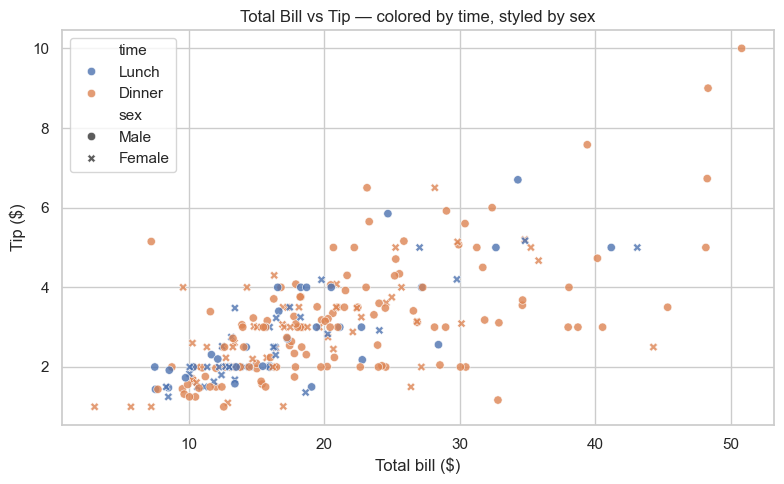

In [2]:
# Scatter plot (direct DataFrame usage)
plt.figure(figsize=(8,5))
sns.scatterplot(data=tips, x="total_bill", y="tip", hue="time", style="sex", alpha=0.8)
plt.title("Total Bill vs Tip — colored by time, styled by sex")
plt.xlabel("Total bill ($)")
plt.ylabel("Tip ($)")
plt.tight_layout()
plt.show()

You can also draw distributions directly from columns.

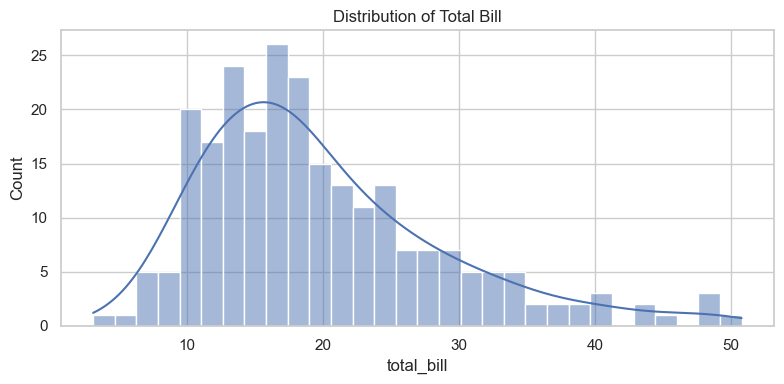

In [3]:
# Histogram + KDE of total_bill
plt.figure(figsize=(8,4))
sns.histplot(data=tips, x="total_bill", kde=True, bins=30)
plt.title("Distribution of Total Bill")
plt.tight_layout()
plt.show()

Boxplots and violinplots are similarly plotted from DataFrame columns.

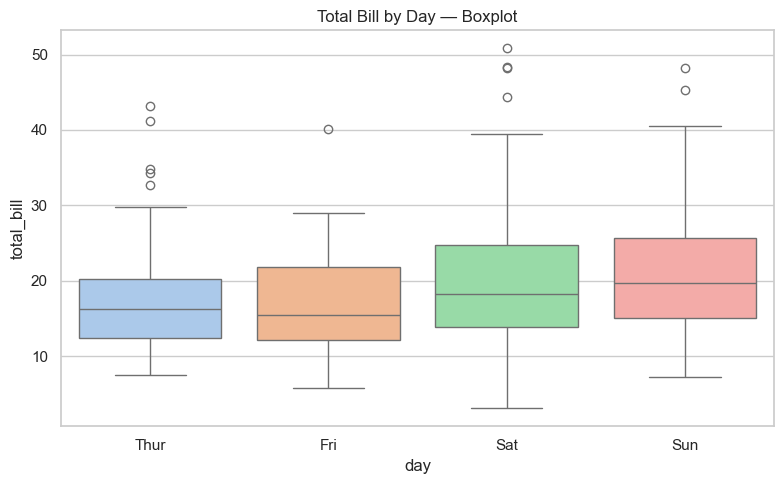

In [6]:
plt.figure(figsize=(8,5))

sns.boxplot(
    data=tips,
    x="day",
    y="total_bill",
    hue="day",       # assign hue to the same variable
    palette="pastel",
    legend=False     # remove redundant legend
)

plt.title("Total Bill by Day — Boxplot")
plt.tight_layout()
plt.show()


## 3 — Using `groupby` + Seaborn
Pandas `groupby` is frequently used to compute summary statistics before plotting. Two common patterns:
1. Pre-aggregate with `groupby().agg()` and plot the result
2. Use transform/merge to add aggregated columns back to the DataFrame and plot with Seaborn


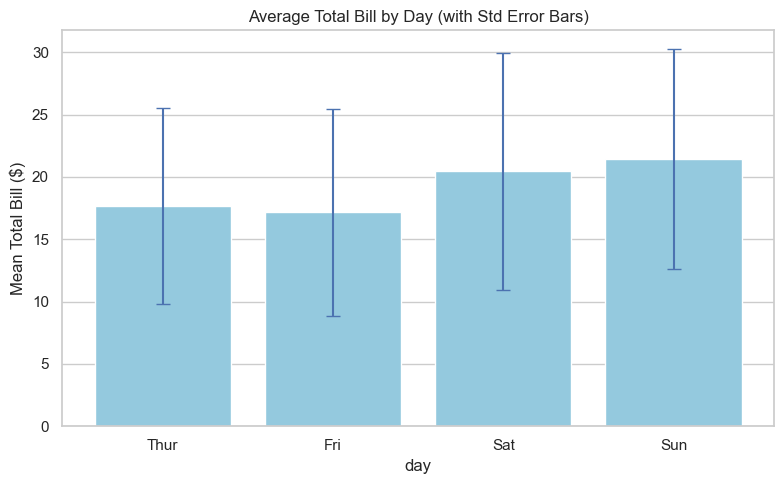

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Fix the FutureWarning
grouped = tips.groupby('day', observed=False)['total_bill'].agg(['mean','std','count']).reset_index()
grouped.columns = ['day','mean_total_bill','std_total_bill','count']

plt.figure(figsize=(8,5))

# Draw bars (no seaborn errorbars)
ax = sns.barplot(
    data=grouped,
    x='day',
    y='mean_total_bill',
    color="skyblue",
    errorbar=None
)

# Add manual error bars
plt.errorbar(
    x=np.arange(len(grouped)),
    y=grouped['mean_total_bill'],
    yerr=grouped['std_total_bill'],
    fmt='none', 
    capsize=5,
    linewidth=1.5
)

plt.title('Average Total Bill by Day (with Std Error Bars)')
plt.ylabel('Mean Total Bill ($)')
plt.tight_layout()
plt.show()


Note: Seaborn's `barplot()` can compute the estimator itself (mean) and show confidence intervals, but pre-aggregating gives you full control over custom statistics.

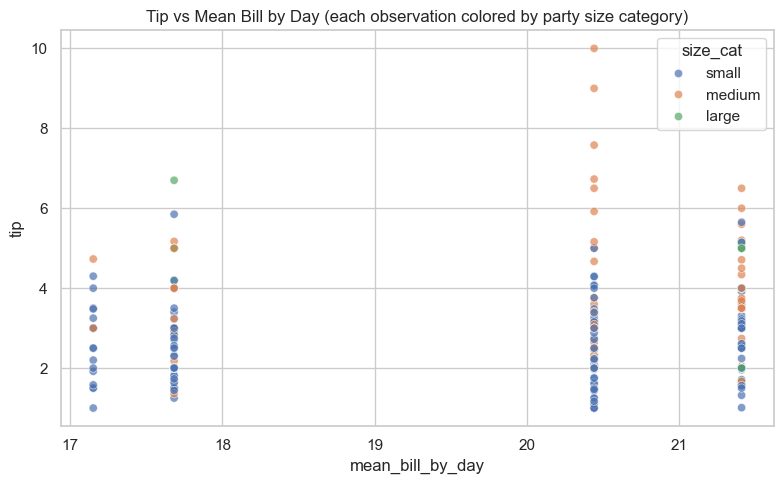

In [9]:
# Pattern 2: Use transform to add group-level stats back to the DataFrame
tips['mean_bill_by_day'] = tips.groupby('day', observed=False)['total_bill'].transform('mean')

# Create size categories
tips['size_cat'] = pd.cut(
    tips['size'],
    bins=[0, 2, 4, 10],
    labels=['small', 'medium', 'large']
)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=tips,
    x='mean_bill_by_day',
    y='tip',
    hue='size_cat',
    alpha=0.7
)
plt.title('Tip vs Mean Bill by Day (each observation colored by party size category)')
plt.tight_layout()
plt.show()


## 4 — Pivot tables + Heatmaps
Pivot tables convert long-form DataFrames into wide-form matrices suitable for heatmaps. We'll create a pivot of mean `total_bill` per (`day`, `time`) and visualize it.

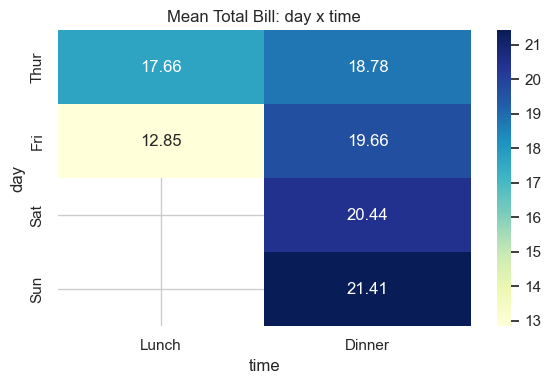

In [11]:
# Pivot table: mean total_bill by day x time
pivot_mean = tips.pivot_table(
    values='total_bill',
    index='day',
    columns='time',
    aggfunc='mean',
    observed=False   # <-- avoid FutureWarning
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_mean, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Mean Total Bill: day x time')
plt.tight_layout()
plt.show()


Heatmaps can also visualize counts, rates or other aggregated metrics. Example: proportion of bills above a threshold.

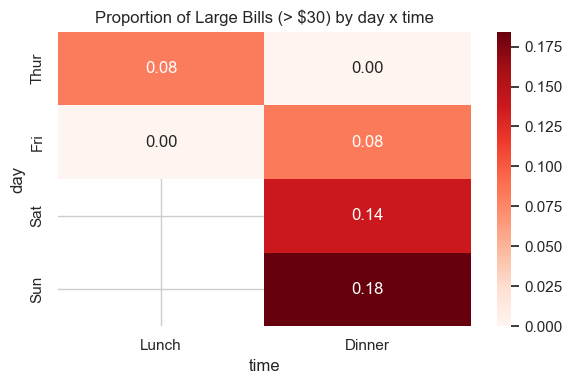

In [13]:
tips['large_bill'] = (tips['total_bill'] > 30).astype(int)

pivot_prop = tips.pivot_table(
    values='large_bill',
    index='day',
    columns='time',
    aggfunc='mean',
    observed=False  # <-- explicitly set to avoid FutureWarning
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot_prop, annot=True, fmt='.2f', cmap='Reds')
plt.title('Proportion of Large Bills (> $30) by day x time')
plt.tight_layout()
plt.show()


### Masking upper/lower triangle (useful for correlation heatmaps)
If you compute a correlation matrix you may want to mask one triangle to avoid redundancy.

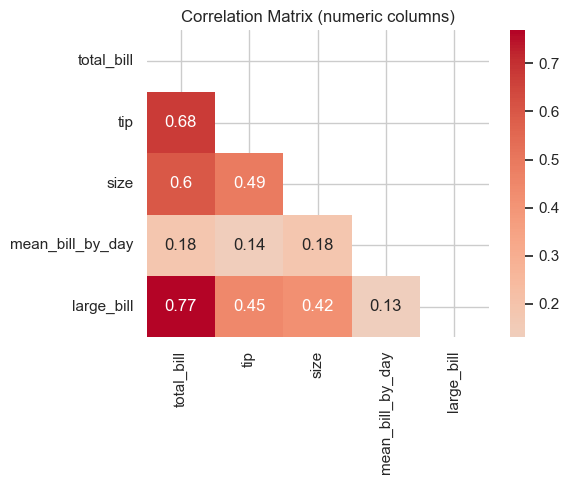

In [14]:
# Correlation heatmap for numeric columns
numeric = tips.select_dtypes(include=['number'])
corr = numeric.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6,5))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (numeric columns)')
plt.tight_layout()
plt.show()

## 5 — Aggregations + Categorical Plots
Seaborn's categorical plots (`barplot`, `pointplot`, `boxplot`, `violinplot`, `catplot`) pair nicely with Pandas aggregations. We'll show multiple patterns:
- Multi-index groupby + plotting
- Using `catplot()` for faceting
        

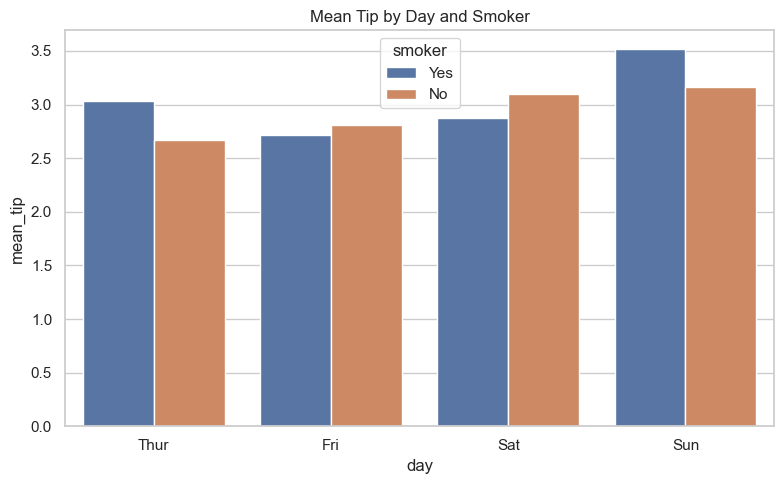

In [16]:
# Multi-index aggregation: mean tip by day and smoker
agg = tips.groupby(['day','smoker'], observed=False)['tip'].agg(['mean','count']).reset_index()
agg.columns = ['day','smoker','mean_tip','count']

plt.figure(figsize=(8,5))
sns.barplot(data=agg, x='day', y='mean_tip', hue='smoker')
plt.title('Mean Tip by Day and Smoker')
plt.tight_layout()
plt.show()


### Catplot for faceted categorical visualizations
`catplot()` is figure-level and convenient for creating grids of categorical plots automatically.

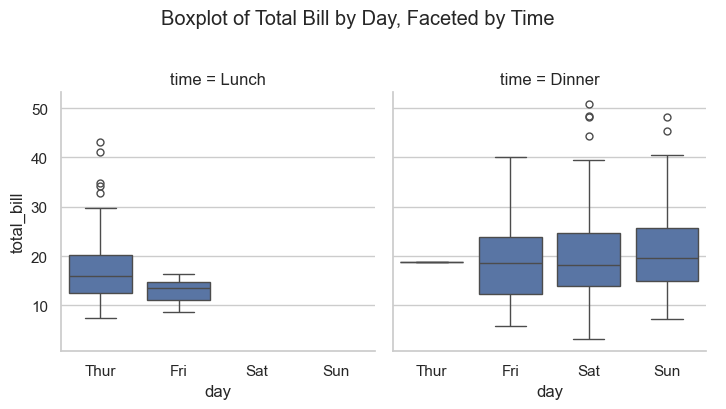

In [17]:
# Boxplots faceted by time
sns.catplot(data=tips, x='day', y='total_bill', col='time', kind='box', height=4, aspect=0.9)
plt.suptitle('Boxplot of Total Bill by Day, Faceted by Time', y=1.02)
plt.tight_layout()
plt.show()

### Point plots (showing mean + confidence interval) with custom aggregation
We will compute group means and plot them with `pointplot()` for clarity.

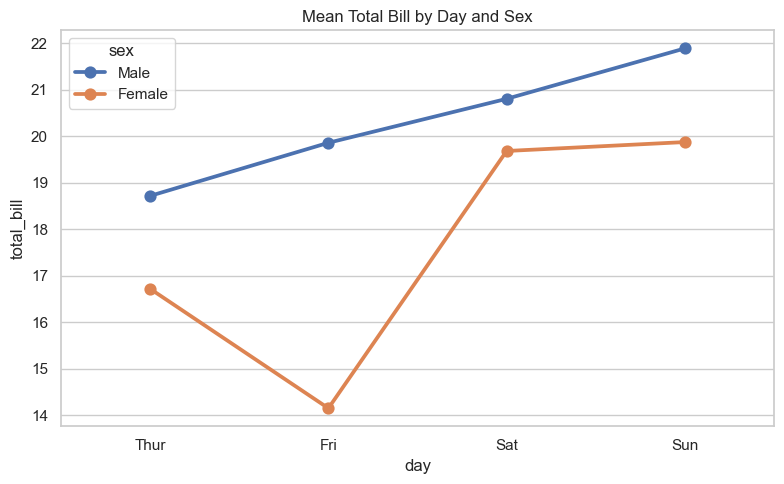

In [19]:
mean_by_day_sex = tips.groupby(['day','sex'], observed=False)['total_bill'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.pointplot(data=mean_by_day_sex, x='day', y='total_bill', hue='sex')
plt.title('Mean Total Bill by Day and Sex')
plt.tight_layout()
plt.show()


### Combining aggregation with violin + swarm for detailed distributions
Violin shows density; swarm overlays raw points without overlap.

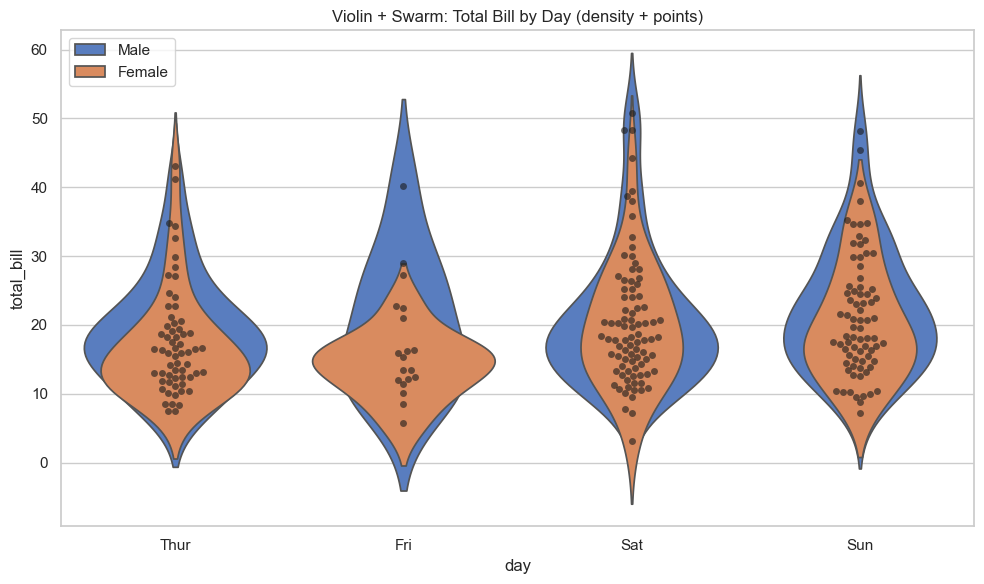

In [23]:
plt.figure(figsize=(10,6))
sns.violinplot(data=tips, x='day', y='total_bill', hue='sex', inner=None, palette='muted', dodge=False)
sns.swarmplot(data=tips, x='day', y='total_bill', color='k', alpha=0.6)
plt.title('Violin + Swarm: Total Bill by Day (density + points)')
plt.tight_layout()
plt.show()


## 6 — Advanced tips & patterns
- Use `pd.crosstab()` for contingency tables and visualize them as heatmaps for categorical relationships.
- Use `pivot_table(..., aggfunc=["mean","count"])` to compute multiple aggregations and inspect both central tendency and sample size.
- When plotting aggregated results with Seaborn, prefer resetting the index (`.reset_index()`) to keep columns accessible by name.
- For very large datasets, consider sampling or using `sns.histplot(..., bins=..., stat="density")` for performance.

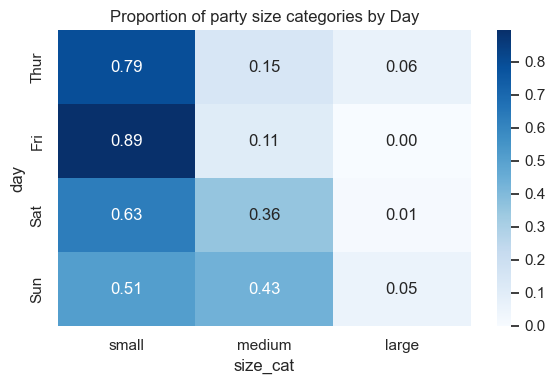

In [24]:
# Example: crosstab of day vs size category (small/medium/large)
tips['size_cat'] = pd.cut(tips['size'], bins=[0,2,4,10], labels=['small','medium','large'])
ct = pd.crosstab(tips['day'], tips['size_cat'], normalize='index')

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt='.2f', cmap='Blues')
plt.title('Proportion of party size categories by Day')
plt.tight_layout()
plt.show()

## 7 — Putting it all together: a short workflow
1. Inspect the DataFrame with `df.head()` and `df.describe()`.
2. Decide which variables are categorical vs numeric.
3. Use `groupby` or `pivot_table` to compute the aggregations you need.
4. Visualize with Seaborn functions that accept `data=` and column names.
5. When needed, add transformed columns to the DataFrame (via `.transform`) to retain long-form structure for Seaborn plotting.


## Final Summary
- Seaborn integrates tightly with Pandas; pass `data=` and column names for concise code.
- Use `groupby().agg()` when you need exact control over aggregations, then plot the resulting summarized DataFrame.
- Pivot tables create matrices for heatmaps — ideal for two-way summaries (day × time, category × category).
- Combine aggregations with categorical plots (barplot, pointplot, catplot) for clear comparison across groups.
- Re-add aggregated values to the original DataFrame with `.transform()` when you want to plot raw observations alongside group summaries.

This notebook gives you a robust, repeatable workflow for exploratory plotting using Seaborn + Pandas.